E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

E06: meta-exercise! Think of a fun/interesting exercise and complete it.

In [2]:
import time
import torch
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

In [54]:
import math

In [3]:
import matplotlib.pyplot as plt

In [4]:
with open('names.txt', 'r') as file:
    words = file.read().splitlines()

# Exercise 1

I do see an improvement.

The goal is to implement a trigram model both using counts and a neural network.

How do we construct these trigrams? What is the idea if we use counts? A trigram is a sequence of three letters. We want to model the probability of seeing a particular letter given the previous two. How do we do that for the beginning of a word? Does a word begin with two '.' elements?

In [ ]:
torch.cuda.is_available()

In [ ]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [ ]:
default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

In [ ]:
def trigrams(words):
    for w in words:
        chs = ['.', '.'] + list(w) + ['.']
        for c1, c2, c3 in zip(chs, chs[1:], chs[2:]):
            yield c1, c2, c3

In [ ]:
chars = sorted(list(set(''.join(words))))

A trigram count model would map two chars to a single char that follows. What dimensions should a count lookup table have? Well, what are all the possible two char sequences that we might have? Certainly can be two dots or it can start with a dot. Can't start with a letter and end with a dot, because that should have terminated evaluation earlier. So the number should be $1\cdot1 + 1\cdot26 + 26\cdot26 = 27\cdot26 + 1 = 27\cdot27-26$.

In [ ]:
DOT = '.'

In [ ]:
btoi = {}
i = 0

btoi[(DOT, DOT)] = i
i += 1

for c in chars:
    btoi[(DOT, c)] = i
    i += 1
    
for c1 in chars:
    for c2 in chars:
        btoi[(c1, c2)] = i
        i += 1

itob = {i: b for b, i in btoi.items()}

ctoi = {}
i = 0

ctoi[DOT] = i
i += 1

for c in chars:
    ctoi[c] = i
    i += 1
    
itoc = {i: c}

itoc = {i: c for c, i in ctoi.items()}

m = len(itob)
n = len(itoc)

# Count-based model

In [ ]:
N = torch.zeros((m, n), dtype=torch.int32, device='cpu')

In [ ]:
for c1, c2, c3 in trigrams(words):
    i1 = btoi[(c1, c2)]
    i2 = ctoi[c3]
    N[i1, i2] += 1

In [ ]:
P = N.float()
P /= P.sum(axis=1, keepdim=True)

In [ ]:
g = torch.Generator(device='cpu').manual_seed(42)

def makeone():
    i = 0
    s = ''
    while True:
        p = P[i]
        ci = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        # now we have a new character index, we need to update our lookup bigram
        # the new lookup bigram will contain the second character in the first position
        # and the new character in the second position
        # what is the current bigram? it is given by i
        if ci == 0:
            break
        i = btoi[(itob[i][1], itoc[ci])]
        s += itoc[ci]
    return s

Now want to evaluate the model. The idea is to calculate the likelihood of the dataset given the model parameters.

In [ ]:
ll = 0
k = 0
for word in words:
    chs = ['.', '.'] + list(word) + ['.']
    for c1, c2, c3 in zip(chs, chs[1:], chs[2:]):
        i1 = btoi[(c1, c2)]
        i2 = ctoi[c3]
        ll += torch.log(P[i1, i2])
        k += 1
print(f"mean negative likelihood is {-ll/k}")

# Gradient descent optimization

Create a dataset. We do this by turning character indices into one hot vector. The first character in a bigram is an $x$, the second character is a $y$.

In [ ]:
xs = []
ys = []
for word in words:
    chs = ['.', '.'] + list(word) + ['.']
    for c1, c2, c3 in zip(chs, chs[1:], chs[2:]):
        i1 = btoi[(c1, c2)]
        i2 = ctoi[c3]
        xs.append(i1)
        ys.append(i2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [ ]:
xenc = F.one_hot(xs, m).to(default_dtype)

In [ ]:
g = torch.Generator(device='cuda').manual_seed(2147483647)
W = torch.randn(m, n, generator=g, requires_grad=True)

In [ ]:
t = time.time()
print(f"{'epoch':>6} {'loss':>10} {'time,s':>7}")
for i in range(10000+1):
    # --- ONE-HOT ---
    logits = xenc @ W # log-counts
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(len(xs)), ys].log().mean()# + 20*(W**2).mean()
    if (i+1)%1000 == 1:
        tt = time.time()
        print(f"{i+1:6} {loss.data.item():10.5f} {tt-t:>7.2f}")
        t = tt

    W.grad = None # zero out the gradients
    loss.backward()
    W.data += -50*W.grad

In [ ]:
i = 0
s = ''
while True:
    xenc = F.one_hot(torch.tensor([i]), m).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    ci = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    if ci == 0:
        break
    i = btoi[(itob[i][1], itoc[ci])]
    s += itoc[ci]
print(s)

# Exercise 2

E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

So to be precise, I want to train and evaluate bigram/trigram count/neural models. Can I encapsulate all these models behind a common interface to make it easier to train and evaluate?

What should that interface be? I want to be able to 1. train 2. evaluate. In 1. I want to pass in an X and a Y nd 

Ok, let's build a count based bigram model class.

Could either split at the word level, or at the character-character/bigram-character level. I should design the classes such that I don't have to worry about that. That is, the functions should operate

I think the count based models boil down to lookup tables. So we should call them lookup models of certain dimensions, and factor out character to index conversion.

In [5]:
DOT = '.'

In [6]:
class CountModel:
    def __init__(self, m, n):
        self.m = m
        self.n = n
    
    def train(self, X, Y, smoothing=0.000001):
        assert len(X.shape) == 1
        assert len(Y.shape) == 1
        assert X.max() < self.m
        assert Y.max() < self.n
        self.N = torch.zeros((self.m, self.n), dtype=torch.int32)
        for i1, i2 in zip(X, Y):
            self.N[i1, i2] += 1
        self.P = self.N.float() + smoothing
        self.P /= self.P.sum(axis=1, keepdim=True)
        
    def eval(self, X, Y):
        assert len(X.shape) == 1
        assert len(Y.shape) == 1
        assert X.max() < self.m
        assert Y.max() < self.n
        ll = sum(torch.log(self.P[i1, i2]) for i1, i2 in zip(X, Y))
        return (-ll/len(X)).item()

Let's just implement what's necessary and package later.

The pipeline in the bigram case is:
Words -> bigrams -> index pairs

In [7]:
class Bigrammer:
    def __init__(self, words):
        self.words = words
        self.chars = sorted(list(set(''.join(self.words))))
        self.ctoi = {s: i+1 for i, s in enumerate(self.chars)}
        self.ctoi[DOT] = 0
        self.itoc = {i: s for s, i in self.ctoi.items()}
        self.m = len(self.itoc)
        self.n = self.m
        
    def bigrams(self):
        for w in self.words:
            chs = [DOT] + list(w) + [DOT]
            for c1, c2 in zip(chs, chs[1:]):
                yield c1, c2
                
    def indexpairs(self):
        for c1, c2 in self.bigrams():
            i1 = self.ctoi[c1]
            i2 = self.ctoi[c2]
            yield i1, i2
            
    def xy(self):
        X = []
        Y = []
        for i1, i2 in self.indexpairs():
            X.append(i1)
            Y.append(i2)
        X = torch.tensor(X)
        Y = torch.tensor(Y)
        return X, Y

Now let's make a neural network model for bigrams. Actually it will work for trigrams as well.

In [282]:
class NeuralModel:
    def __init__(self, m, n, device='cpu', seed=2147483647, onehot=True, crossentropy=True):
        self.crossentropy = crossentropy
        self.onehot = onehot
        self.seed = seed
        self.m = m
        self.n = n
        self.device = device
        self._reset()

    def _reset(self):
        g = torch.Generator().manual_seed(self.seed)
        self.W = torch.randn(self.m, self.n, generator=g).to(self.device)
        self.W.requires_grad = True
    
    def _forward(self, X, Y, regularization):
        if self.onehot:
            logits = X @ self.W # log-counts
        else:
            logits = self.W[X]

        if self.crossentropy:
            a = F.cross_entropy(logits, Y)
        else:
            counts = logits.exp()
            probs = counts / counts.sum(1, keepdims=True)
            a = -probs[torch.arange(len(X)), Y].log().mean()
        b = regularization*(self.W**2).mean()
        loss = a + b
        return loss, a, b
    
    def train(self, X, Y, epochs=1000, verbose=False, every=100, lr=1, reset=True, regularization=0):
        assert len(X.shape) == 1
        assert len(Y.shape) == 1
        assert X.max() < self.m
        assert Y.max() < self.n
        if self.onehot:
            X = F.one_hot(X, self.m).float()
        X = X.to(self.device)
        Y = Y.to(self.device)
        if reset:
            self._reset()
        if verbose:
            print(f"{'epoch':>6} {'loss':>10} {'main':>10} {'reg':>10} {'time,s':>7}")
        loss, main, reg = self._forward(X, Y, regularization=regularization)
        if verbose:
            print(f"{0:6} {loss.data.item():10.5f} {main.data.item():10.5f} {reg.data.item():10.5f}")
        start = time.time()
        for i in tqdm(range(epochs)):
            self.W.grad = None # zero out the gradients
            loss.backward()
            self.W.data += -lr*self.W.grad
            loss, main, reg = self._forward(X, Y, regularization=regularization)
            if verbose and (i==epochs-1 or (i+1)%every == 0):
                end = time.time()
                print(f"{i+1:6} {loss.data.item():10.5f} {main.data.item():10.5f} {reg.data.item():10.5f} {end-start:>7.2f}")
                start = end

    def eval(self, X, Y, regularization=0):
        assert len(X.shape) == 1
        assert len(Y.shape) == 1
        assert X.max() < self.m
        assert Y.max() < self.n
        if self.onehot:
            X = F.one_hot(X, self.m).float()
        X = X.to(self.device)
        Y = Y.to(self.device)
        loss, main, reg = self._forward(X, Y, regularization)
        return loss.item()

Now just need to make a trigrammer.

In [9]:
class Trigrammer:
    def __init__(self, words):
        self.words = words
        chars = sorted(list(set(''.join(self.words))))
        
        self.btoi = {}
        i = 0
        self.btoi[(DOT, DOT)] = i
        i += 1
        for c in chars:
            self.btoi[(DOT, c)] = i
            i += 1
        for c1 in chars:
            for c2 in chars:
                self.btoi[(c1, c2)] = i
                i += 1

        self.itob = {i: b for b, i in self.btoi.items()}

        self.ctoi = {}
        i = 0
        self.ctoi[DOT] = i
        i += 1
        for c in chars:
            self.ctoi[c] = i
            i += 1
        self.itoc = {i: c}
        self.itoc = {i: c for c, i in self.ctoi.items()}

        self.m = len(self.itob)
        self.n = len(self.itoc)
        
    def trigrams(self):
        for w in self.words:
            chs = ['.', '.'] + list(w) + ['.']
            for c1, c2, c3 in zip(chs, chs[1:], chs[2:]):
                yield c1, c2, c3
                
    def indexpairs(self):
        for c1, c2, c3 in self.trigrams():
            i1 = self.btoi[(c1, c2)]
            i2 = self.ctoi[c3]
            yield i1, i2
            
    def xy(self):
        X = []
        Y = []
        for i1, i2 in self.indexpairs():
            X.append(i1)
            Y.append(i2)
        X = torch.tensor(X)
        Y = torch.tensor(Y)
        return X, Y

How do I split? I can split into arbitrarily many subsets if I can split into two of arbitrary sizes. E.g. first split into 80 and 20, then split the 20 in half.

I need to split both xs and ys. How? Can I merge them into a single tensor first?

In [10]:
def split(x, device='cpu'):

    g=torch.Generator(device=device).manual_seed(42)
    
    n = len(x)
    indices = torch.randperm(n, generator=g)

    a, b = 0, round(0.8 * n)
    train = x[indices[a:b]]

    a, b = b, b+round(0.1*n)
    dev = x[indices[a:b]]

    a, b = b, n
    test = x[indices[a:b]]
    
    return train, dev, test

In [11]:
def evaluate(model, train, dev, test, **kwargs):
    Xtrain, Ytrain = train
    Xdev, Ydev = dev
    Xtest, Ytest = test
    model.train(Xtrain, Ytrain, **kwargs)
    results = {
        'train': model.eval(Xtrain, Ytrain),
        'dev': model.eval(Xdev, Ydev),
        'test': model.eval(Xtest, Ytest),
    }
    for name, result in results.items():
        print(f"{name:5}: {result:.4f}")

In [115]:
b = Bigrammer(words)
X2, Y2 = b.xy()
XY2 = torch.stack((X2, Y2), dim=1)
train2, dev2, test2 = (x.permute((1, 0)) for x in split(XY2))

In [23]:
evaluate(CountModel(b.m, b.n), train2, dev2, test2)

train: 2.4533
dev  : 2.4650
test : 2.4639


In [118]:
evaluate(NeuralModel(b.m, b.n), train2, dev2, test2, lr=50, epochs=500)

train: 2.4560
dev  : 2.4617
test : 2.4623


In [181]:
t = Trigrammer(words)
X3, Y3 = t.xy()
XY3 = torch.stack((X3, Y3), dim=1)
train3, dev3, test3 = (x.permute((1, 0)) for x in split(XY3))

In [26]:
evaluate(CountModel(t.m, t.n), train3, dev3, test3)

train: 2.1819
dev  : 2.2857
test : 2.3029


In [27]:
evaluate(NeuralModel(t.m, t.n), train3, dev3, test3, lr=50, epochs=100)

train: 2.5039
dev  : 2.5086
test : 2.5116


In all cases the model does worse on the test/dev subsets than on the train.

# Exercise 3

E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

1. try different strengths of smoothing/regularization and check which works best on the dev set
2. compare train vs dev loss during the process
3. find out the loss on the test set using the best setting

Ok, let's try the count based model using different smoothing parameters.

What is the workflow? I train with different smoothing parameters, then check the loss on the dev set. Do that for a number of smoothing values.

Why trigram specifically?

In [12]:
smoothing = [10**k for k in range(-10, 2)]

In [175]:
X3train, Y3train = train3
X3dev, Y3dev = dev3
X3test, Y3test = test3

In [212]:
c = CountModel(t.m, t.n)

counttrain = []
countdev = []

for s in tqdm(smoothing):
    c.train(X3train, Y3train, smoothing=s)
    counttrain.append(c.eval(X3train, Y3train))
    countdev.append(c.eval(X3dev, Y3dev))

  0%|          | 0/12 [00:00<?, ?it/s]

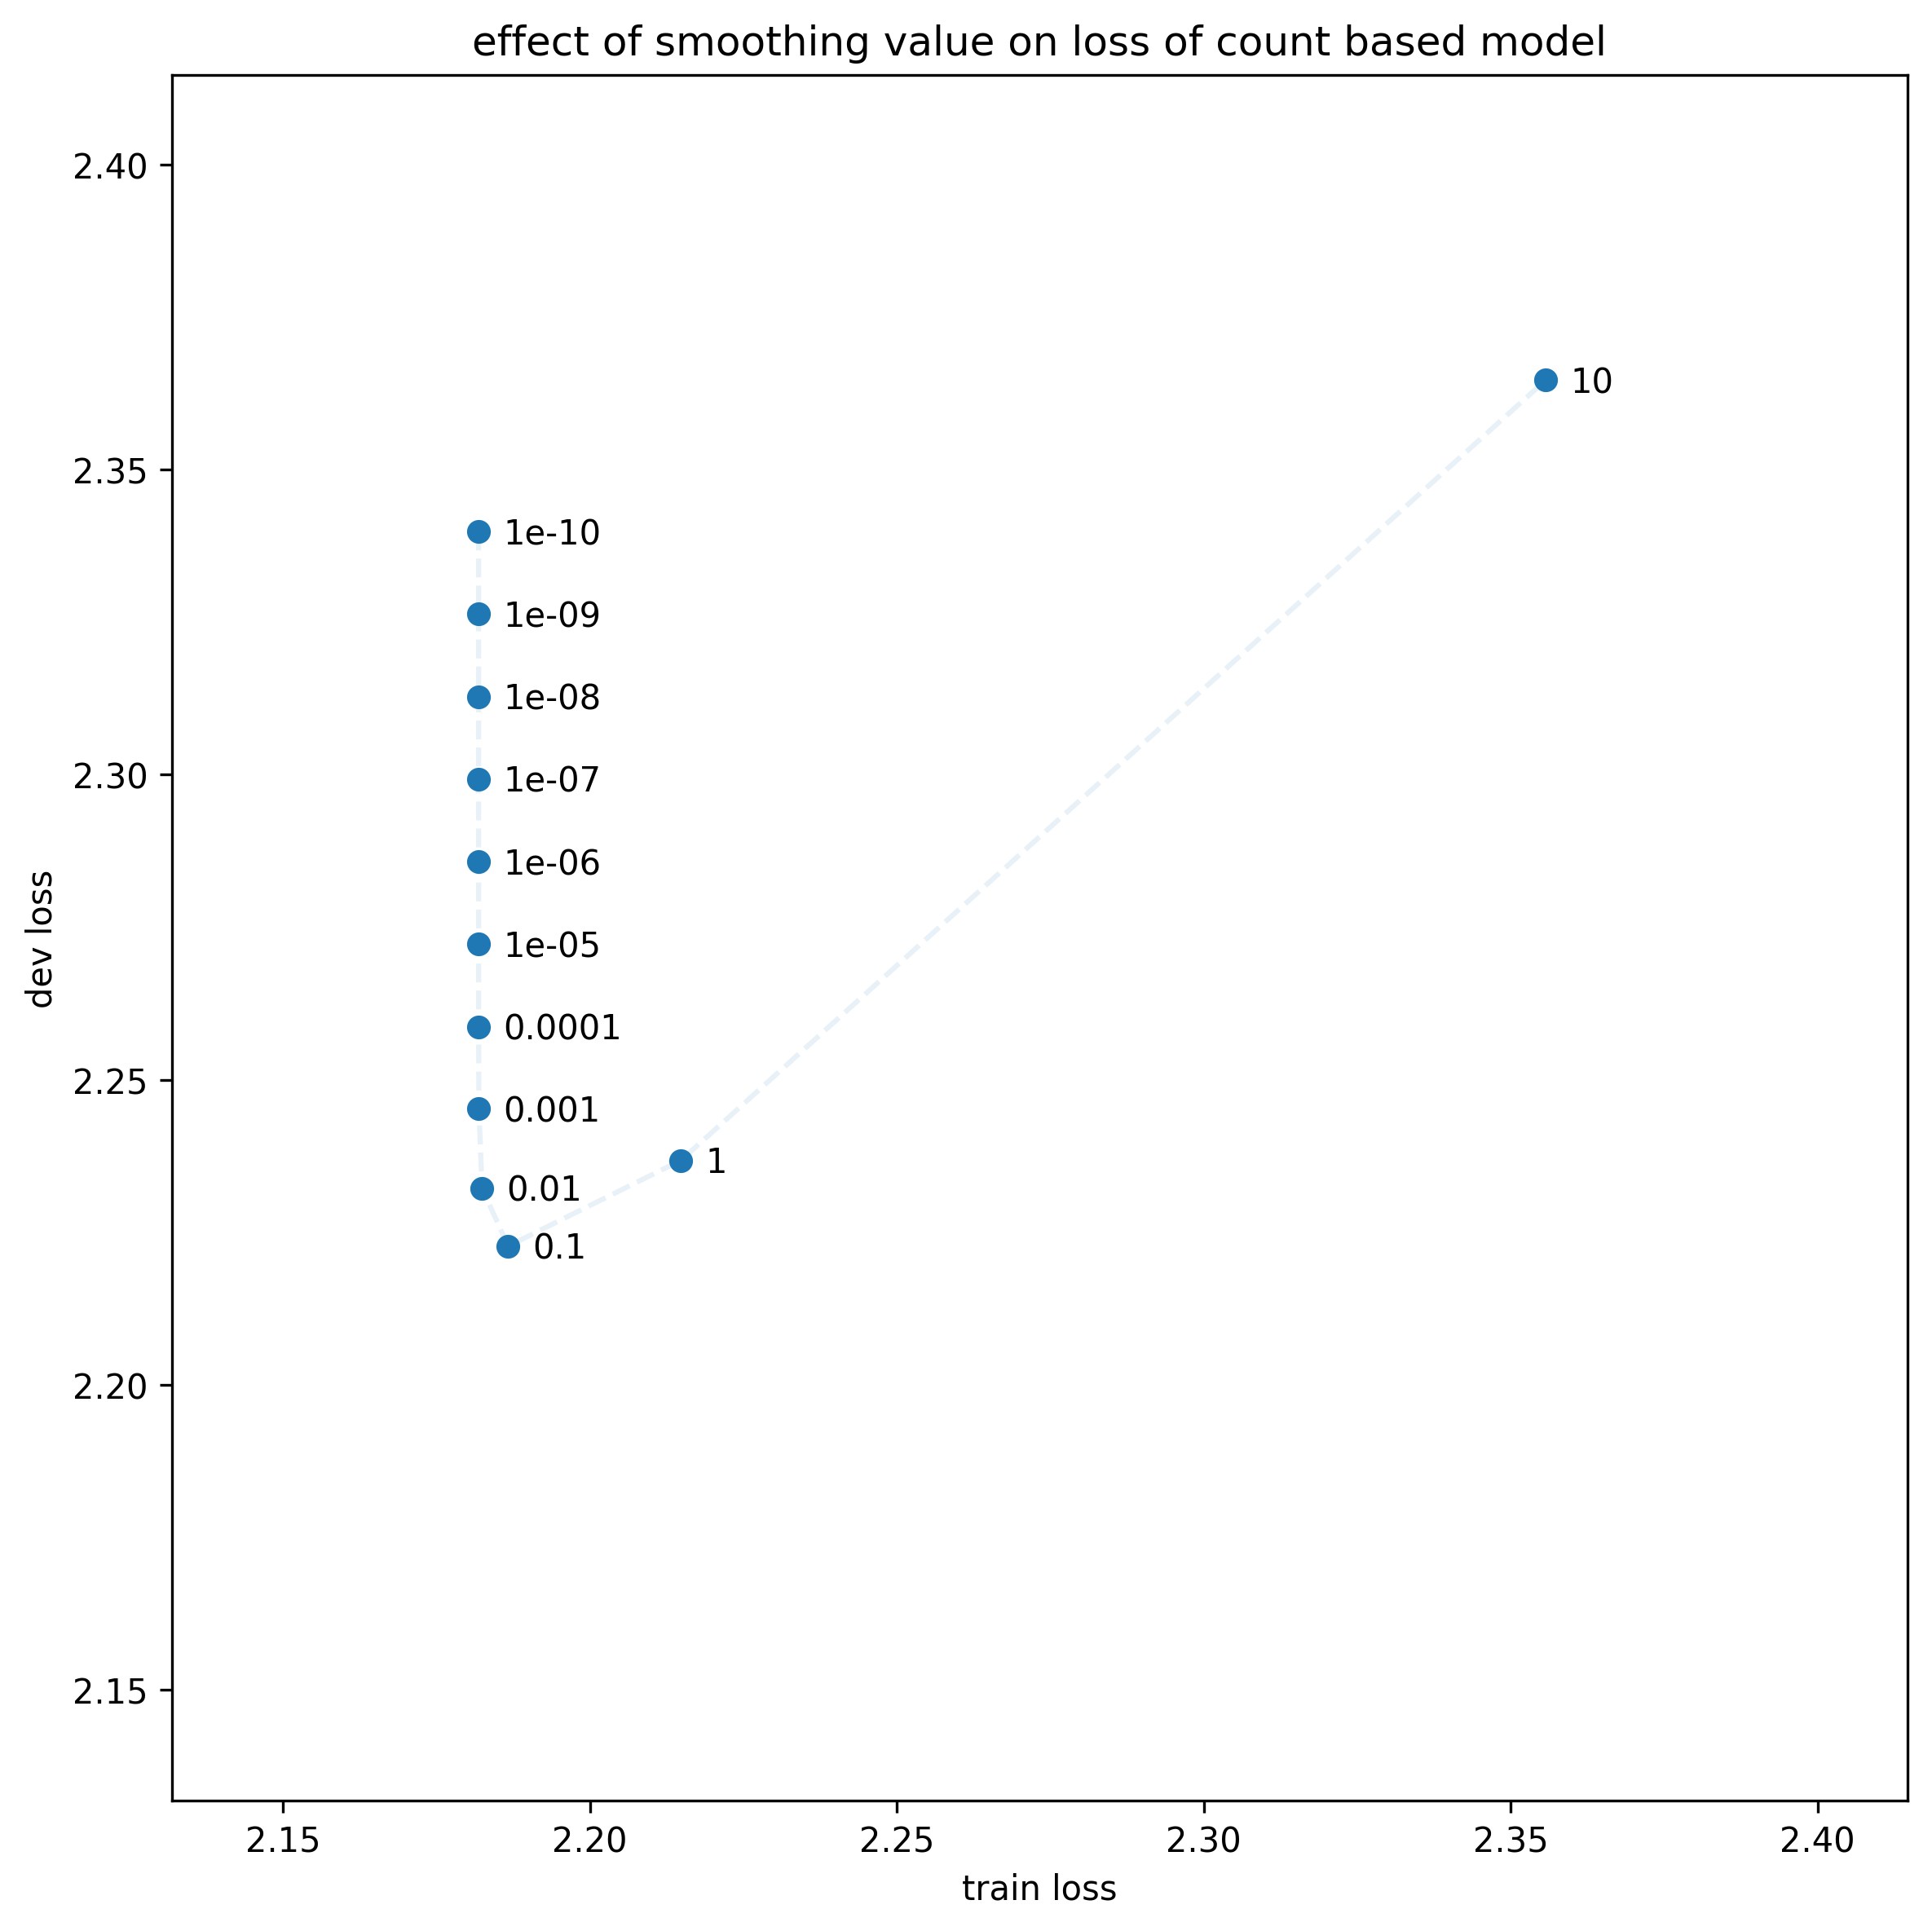

In [179]:
a = min(min(counttrain), min(countdev)) - 0.05
b = max(max(counttrain), max(countdev)) + 0.05

fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
ax.set_xlim(a, b)
ax.set_ylim(a, b)
ax.scatter(counttrain, countdev)
ax.set_xlabel("train loss")
ax.set_ylabel("dev loss")
ax.plot(counttrain, countdev, '--', alpha=0.1, )
ax.set_title("effect of smoothing value on loss of count based model")
for sm, tr, de in zip(smoothing, counttrain, countdev):
    ax.annotate(sm, (tr+0.004, de-0.002))
fig.tight_layout()
#fig.savefig('count-smoothing.png', transparent=False, facecolor='white')

In [182]:
regularization = [10**k for k in range(-5, 5)]

In [220]:
n = NeuralModel(t.m, t.n, device='cuda')

neuraltrain = []
neuraldev = []
for r in tqdm(regularization):
    n.train(X3train, Y3train, regularization=r, lr=50, epochs=2000)
    neuraltrain.append(n.eval(X3train, Y3train))
    neuraldev.append(n.eval(X3dev, Y3dev))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

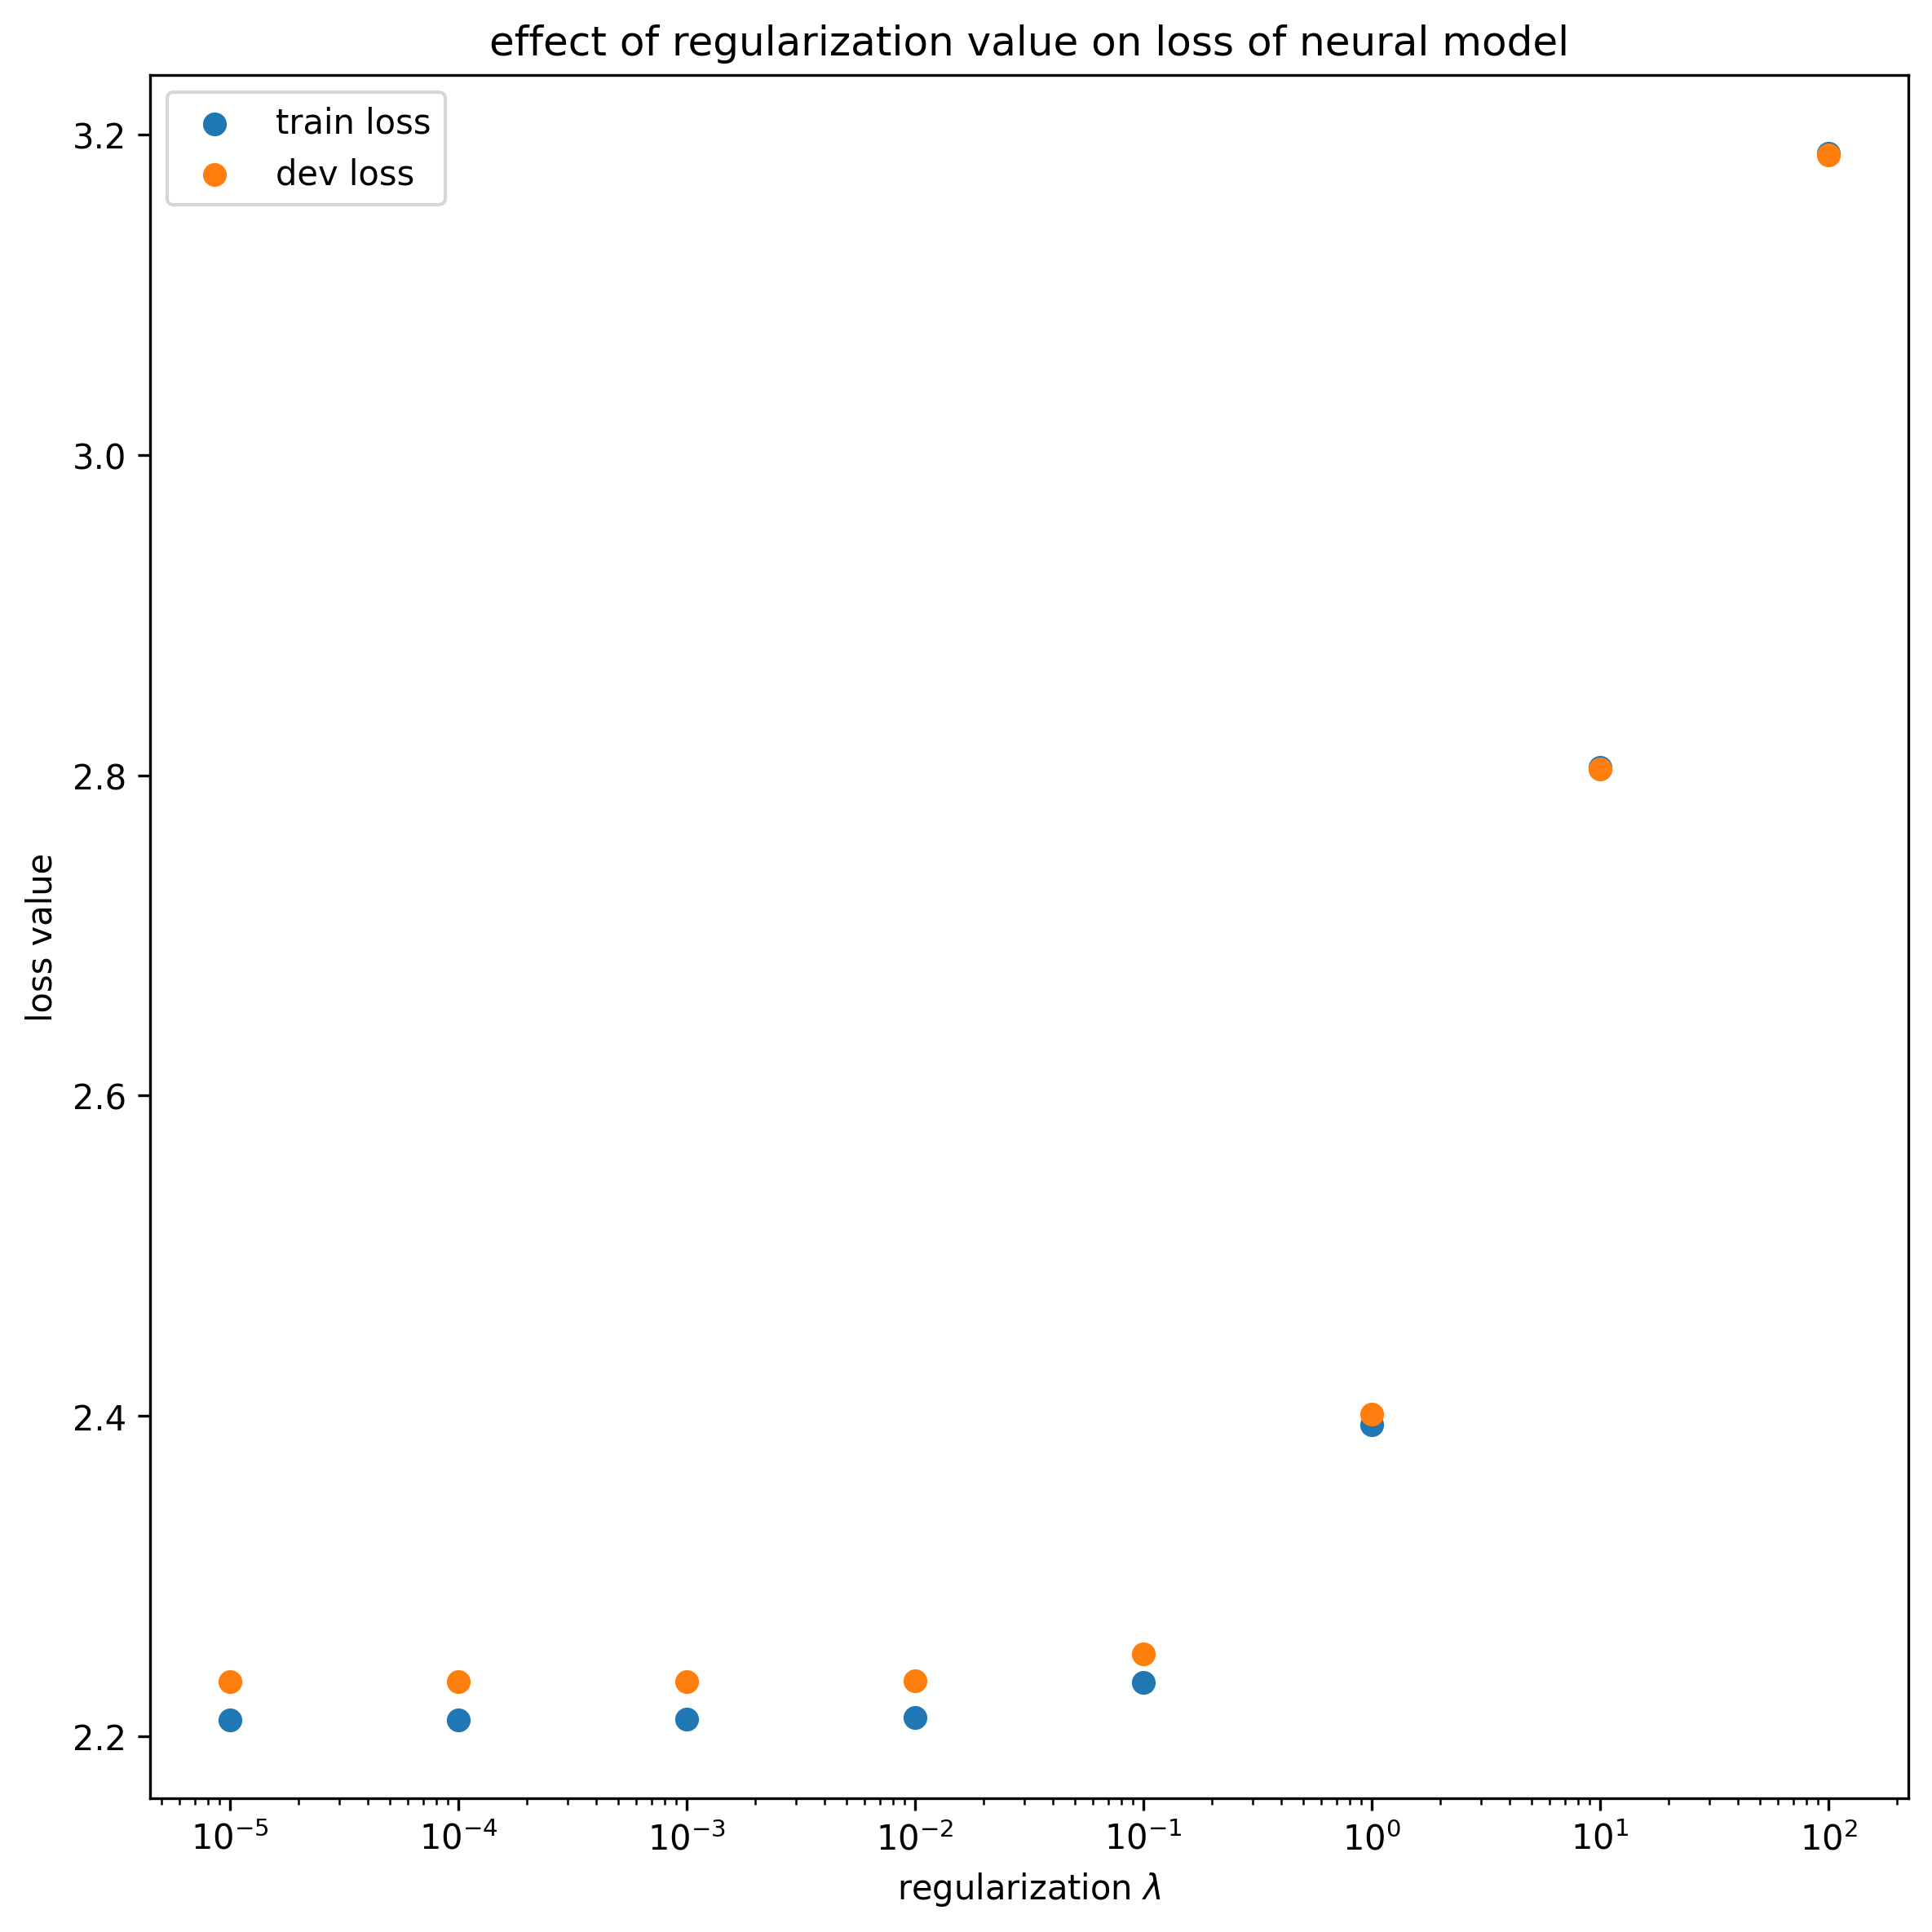

In [221]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
ax.scatter(regularization, neuraltrain, label="train loss")
ax.scatter(regularization, neuraldev, label="dev loss")
ax.set_title("effect of regularization value on loss of neural model")
ax.set_xlabel("regularization $\lambda$")
ax.set_ylabel("loss value")
ax.set_xscale('log')
ax.legend()
fig.tight_layout()
#fig.savefig('neural-regularization.png', transparent=False, facecolor='white')
#ax.set_xlim(a, b)
#ax.set_ylim(a, b)
#ax.scatter(x, y)

I'm assuming the "best setting" is one that did the best on the dev set.

In [227]:
c = CountModel(t.m, t.n)
c.train(X3train, Y3train, smoothing=0.1)
c.eval(X3train, Y3train), c.eval(X3dev, Y3dev), c.eval(X3test, Y3test)

(2.186677932739258, 2.2227368354797363, 2.2312815189361572)

In [228]:
n = NeuralModel(t.m, t.n, device='cuda')
n.train(X3train, Y3train, regularization=0, lr=50)
n.eval(X3train, Y3train), n.eval(X3dev, Y3dev), n.eval(X3test, Y3test)

  0%|          | 0/1000 [00:00<?, ?it/s]

(2.233194351196289, 2.2517154216766357, 2.260007619857788)

# Exercise 4

Indexing definitely speeds the model up on CPU.

In [243]:
n = NeuralModel(t.m, t.n, device='cpu')
n.train(X3train, Y3train, epochs=100)
n.eval(X3train, Y3train)

  0%|          | 0/100 [00:00<?, ?it/s]

3.571923017501831

In [244]:
n = NeuralModel(t.m, t.n, device='cpu', onehot=False)
n.train(X3train, Y3train, epochs=100)
n.eval(X3train, Y3train)

  0%|          | 0/100 [00:00<?, ?it/s]

3.571923017501831

But slows it down on GPU.

In [245]:
n = NeuralModel(t.m, t.n, device='cuda')
n.train(X3train, Y3train, epochs=100)
n.eval(X3train, Y3train)

  0%|          | 0/100 [00:00<?, ?it/s]

3.571922779083252

In [246]:
n = NeuralModel(t.m, t.n, device='cuda', onehot=False)
n.train(X3train, Y3train, epochs=100)
n.eval(X3train, Y3train)

  0%|          | 0/100 [00:00<?, ?it/s]

3.5719234943389893

# Exercise 5

It's a commonly used component, so one benefit is that it's good to have a reference implementation instead of doing by hand every time or rolling your own library.

Strangely, it's faster for 100 epochs but slower for 1000.

Hopefully this effect is only visible for small networks like this one, otherwise it's kind of depressing.

In [283]:
n = NeuralModel(t.m, t.n, device='cuda', crossentropy=True)
n.train(X3train, Y3train, epochs=100)
n.eval(X3train, Y3train)

  0%|          | 0/100 [00:00<?, ?it/s]

3.571927309036255

In [284]:
n = NeuralModel(t.m, t.n, device='cuda', crossentropy=False)
n.train(X3train, Y3train, epochs=100)
n.eval(X3train, Y3train)

  0%|          | 0/100 [00:00<?, ?it/s]

3.571922779083252

In [285]:
n = NeuralModel(t.m, t.n, device='cuda', crossentropy=True)
n.train(X3train, Y3train, epochs=1000)
n.eval(X3train, Y3train)

  0%|          | 0/1000 [00:00<?, ?it/s]

2.9753899574279785

In [286]:
n = NeuralModel(t.m, t.n, device='cuda', crossentropy=False)
n.train(X3train, Y3train, epochs=1000)
n.eval(X3train, Y3train)

  0%|          | 0/1000 [00:00<?, ?it/s]

2.975388526916504

# Exercise 6

I'm curious about the underlying dimensionality of the data.

In [16]:
from sklearn.decomposition import PCA

In [23]:
c2 = CountModel(b.m, b.n)
c2.train(X2, Y2)
s2 = PCA().fit(c2.P).singular_values_

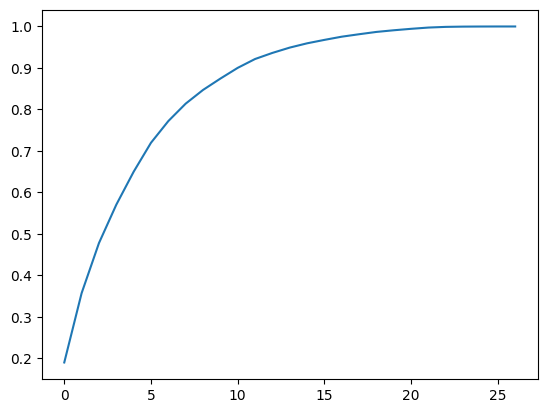

In [24]:
plt.plot(s2.cumsum()/s2.sum())

In [26]:
c3 = CountModel(t.m, t.n)
c3.train(X3, Y3)
s3 = PCA().fit(c3.P).singular_values_

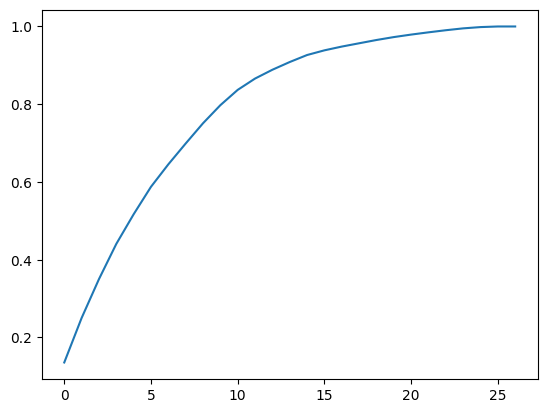

In [27]:
plt.plot(s3.cumsum()/s3.sum())